# Personal Information
Name: **Ronald Vlaar**

StudentID: **12871524**

Email: [**ronald.vlaar@student.uva.nl**]

Submitted on: **22.03.2024**

Github: https://github.com/ronaldvlaar/prototype_segmentation

TODO:

- Include summary of data (counts etc)
- Show some samples
- Show the segmentation done by ProtoSeg
- Train test split same as protoseg for both datasets
- Check how classes are distrubted for both datasets within and across images
- show IoU for an prediction vs actual using the getIouScoreForLabel in evalPixelLevelSemanticLabeling.py (C:\Users\RonaldVl\.pyenv\pyenv-win\versions\3.10.5\Lib\site-packages\cityscapesscripts\evaluation)

# Data Context
**In this section you should introduce the datasources and datasets which you will be working with. Explain where they are from as well as their domain. Give an overview of what the context of the data is. You should not spend more than 1 to 2 paragraphs here as the core information will be in the next section.**

The first dataset used is the Cityscapes dataset. This dataset can be downloaded from https://www.cityscapes-dataset.com/downloads/. The gtFine_trainvaltest.zip and leftlmgbit_trainvaltest.zip are needed. The domain is image segmentation.


The second dataset is an augmented version of the PASCAL VOC 2012 dataset. The domain is image segmentation. Instruction for downloading the data may be found here https://github.com/kazuto1011/deeplab-pytorch/blob/master/data/datasets/voc12/README.md. The augmented variant (SegmentationAug and SegmentationClassAug) should be downloaded.



The data will be used to train and evaluate a model for image segmentation. We want to improve the ProtoSeg (https://arxiv.org/pdf/2301.12276.pdf) baseline model for image segmentation. This model uses part-prototypes for making its predictions explainable, in contrast too deep learning methods like U-Net and DeepLab.

# Data Description

**Present here the results of your exploratory data analysis. Note that there is no need to have a "story line" - it is more important that you show your understanding of the data and the methods that you will be using in your experiments (i.e. your methodology).**

**As an example, you could show data, label, or group balances, skewness, and basic characterizations of the data. Information about data frequency and distributions as well as results from reduction mechanisms such as PCA could be useful. Furthermore, indicate outliers and how/why you are taking them out of your samples, if you do so.**

**The idea is, that you conduct this analysis to a) understand the data better but b) also to verify the shapes of the distributions and whether they meet the assumptions of the methods that you will attempt to use. Finally, make good use of images, diagrams, and tables to showcase what information you have extracted from your data.**

As you can see, you are in a jupyter notebook environment here. This means that you should focus little on writing text and more on actually exploring your data. If you need to, you can use the amsmath environment in-line: $e=mc^2$ or also in separate equations such as here:

\begin{equation}
    e=mc^2 \mathrm{\space where \space} e,m,c\in \mathbb{R}
\end{equation}

Furthermore, you can insert images such as your data aggregation diagrams like this:

![image](example.png)

In [25]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import seaborn_image as isns

### Data Loading

The data is loaded and preprocessed using the segmentation.preprocess_cityscapes and segmentation.preprocess_pascal modules from ProtoSeg (https://github.com/gmum/proto-segmentation).

In [26]:
# Mapping from protoseg
"""
Some constants related to Cityscapes and PASCAL datasets
"""

# Taken from deeplabv2 trained on ImageNet
CITYSCAPES_MEAN = [0.485, 0.456, 0.406]
CITYSCAPES_STD = [0.229, 0.224, 0.225]

# Mapping of IDs to labels
# We follow https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
# We merge 'void' classes into one but other classes stay the same

CITYSCAPES_ID_2_LABEL = {
    0: 'void',
    1: 'void',
    2: 'void',
    3: 'void',
    4: 'void',
    5: 'void',
    6: 'void',
    7: 'road',
    8: 'sidewalk',
    9: 'parking',
    10: 'rail track',
    11: 'building',
    12: 'wall',
    13: 'fence',
    14: 'guard rail',
    15: 'bridge',
    16: 'tunnel',
    17: 'pole',
    18: 'polegroup',
    19: 'traffic light',
    20: 'traffic sign',
    21: 'vegetation',
    22: 'terrain',
    23: 'sky',
    24: 'person',
    25: 'rider',
    26: 'car',
    27: 'truck',
    28: 'bus',
    29: 'caravan',
    30: 'trailer',
    31: 'train',
    32: 'motorcycle',
    33: 'bicycle',
    -1: 'license plate'
}

CITYSCAPES_CATEGORIES = [
    'void',
    'road',
    'sidewalk',
    'parking',
    'rail track',
    'building',
    'wall',
    'fence',
    'guard rail',
    'bridge',
    'tunnel',
    'pole',
    'polegroup',
    'traffic light',
    'traffic sign',
    'vegetation',
    'terrain',
    'sky',
    'person',
    'rider',
    'car',
    'truck',
    'bus',
    'caravan',
    'trailer',
    'train',
    'motorcycle',
    'bicycle',
    'license plate'
]

CITYSCAPES_19_EVAL_CATEGORIES = {
    0: 0,
    1: 1,
    2: 2,
    3: 0,
    4: 0,
    5: 3,
    6: 4,
    7: 5,
    8: 0,
    9: 0,
    10: 0,
    11: 6,
    12: 0,
    13: 7,
    14: 8,
    15: 9,
    16: 10,
    17: 11,
    18: 12,
    19: 13,
    20: 14,
    21: 15,
    22: 16,
    23: 0,
    24: 0,
    25: 17,
    26: 18,
    27: 19,
    28: 0,
}

PASCAL_ID_MAPPING = {
    255: 0,
    0: 1,
    1: 2,
    2: 3,
    3: 4,
    4: 5,
    5: 6,
    6: 7,
    7: 8,
    8: 9,
    9: 10,
    10: 11,
    11: 12,
    12: 13,
    13: 14,
    14: 15,
    15: 16,
    16: 17,
    17: 18,
    18: 19,
    19: 20,
    20: 21
}

PASCAL_CATEGORIES = [
    'void',
    '__background__',
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

In [27]:
# Converters
convert_cityscapes = np.vectorize(CITYSCAPES_19_EVAL_CATEGORIES.get)
convert_pascal = np.vectorize(PASCAL_ID_MAPPING.get)

### Analysis 1: 
Below we show an instance of an input image and the ground truth for both the PASCAL VOC 12 and cityscape datasets.

In [28]:
def plot_images(im1_path, im1_title, im2_path, im2_title):
    print(im1_path, im2_path)
    # Load .npy images
    image1 = np.load(im1_path) if im1_path[-3:] == 'npy' else np.array(mpimg.imread(im1_path))
    image2 = np.load(im2_path) if im2_path[-3:] == 'npy' else np.array(mpimg.imread(im2_path))

    # Plotting
    fig, ax =plt.subplots(1, 2)

    ax[0].imshow(image1)
    ax[0].set_title(im1_title)

    ax[1].imshow(image2)
    ax[1].set_title(im2_title)



    # plt.subplot(1, 2, 1)
    # isns.imgplot(image1)
    # plt.title(im1_title)

    # plt.subplot(1, 2, 2)
    # isns.imgplot(image2)
    # plt.title(im2_title)

    plt.tight_layout()
    plt.show()

PASCAL VOC12

../VOC12/annotations/train_aug/2007_000032.npy ../VOC12/img_with_margin_0/train/2007_000032.npy


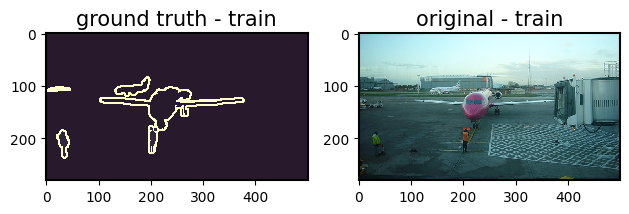

categories in sample 4
categories ['void' '__background__' 'aeroplane' 'person']


In [29]:
# File paths of the .npy images
root = '../VOC12/annotations/'
test = root+' test/'
train = root+'train/'
train_aug = root+'train_aug/'
val = root+'val/'

root_src = '../VOC12/img_with_margin_0/'
test_src = root_src+' test/'
train_src = root_src+'train/'
train_aug_src = root_src+'train_aug/'
val_src = root_src+'val/'
f = '2007_000032.npy'

plot_images(train_aug+f, 'ground truth - train', train_src+f, 'original - train')

label = np.load(train_aug+f).astype(np.uint8)

categories = np.array(PASCAL_CATEGORIES)[np.unique(convert_pascal(label))]
print('categories in sample', len(categories))
print('categories', categories)

Cityscapes

../cityscapes/annotations/train/aachen_000000_000019.npy ../cityscapes/img_with_margin_0/train/aachen_000000_000019.png


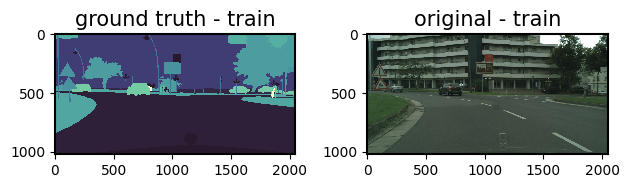

categories in sample 13
categories ['void' 'road' 'sidewalk' 'parking' 'wall' 'guard rail' 'bridge' 'tunnel'
 'pole' 'polegroup' 'traffic light' 'traffic sign' 'rider']


In [30]:
cs_root = '../cityscapes/annotations/'
cs_test = cs_root+' test/'
cs_train = cs_root+'train/'
cs_val = cs_root+'val/'

cs_root_src = '../cityscapes/img_with_margin_0/'
cs_test_src = cs_root_src+' test/'
cs_train_src = cs_root_src+'train/'
cs_val_src = cs_root_src+'val/'
f = 'aachen_000000_000019.npy'

plot_images(cs_train+f, 'ground truth - train', cs_train_src+f[:-3]+'png', 'original - train')
label = np.load(cs_train+f).astype(np.uint8)

categories = np.array(CITYSCAPES_CATEGORIES)[np.unique(convert_cityscapes(label))]
print('categories in sample', len(categories))
print('categories', categories)

In [31]:
# cs_root_src = '../cityscapes/img_with_margin_0/'
# cs_test_src = cs_root_src+' test/'
# cs_train_src = cs_root_src+'train/'
# cs_val_src = cs_root_src+'val/'
# f = 'aachen_000000_000019.npy'
# f_obj = 'aachen_000000_000019_obj_mask.npy'

# plot_images(cs_train+f_obj, 'ground truth - train', cs_train_src+f[:-3]+'png', 'original - train')

# label = np.load(cs_train+f_obj).astype(np.uint8)
# categories = np.array(CITYSCAPES_CATEGORIES)[np.unique(label)]
# print('categories in sample', len(categories))
# print('categories', categories)

### Analysis 2: 

Below are the splits per dataset and their counts

In [40]:
import json

with open('../VOC12/all_images.json', 'r') as f:
    pascal_data = json.load(f)

pascal_data

with open('../Cityscapes/all_images.json', 'r') as f:
    cs_data = json.load(f)

cs_data

{'train': ['aachen_000000_000019',
  'aachen_000001_000019',
  'aachen_000002_000019',
  'aachen_000003_000019',
  'aachen_000004_000019',
  'aachen_000005_000019',
  'aachen_000006_000019',
  'aachen_000007_000019',
  'aachen_000008_000019',
  'aachen_000009_000019',
  'aachen_000050_000019',
  'aachen_000051_000019',
  'aachen_000052_000019',
  'aachen_000053_000019',
  'aachen_000054_000019',
  'aachen_000055_000019',
  'aachen_000056_000019',
  'aachen_000057_000019',
  'aachen_000058_000019',
  'aachen_000059_000019',
  'aachen_000060_000019',
  'aachen_000061_000019',
  'aachen_000062_000019',
  'aachen_000063_000019',
  'aachen_000064_000019',
  'aachen_000065_000019',
  'aachen_000066_000019',
  'aachen_000067_000019',
  'aachen_000068_000019',
  'aachen_000069_000019',
  'aachen_000010_000019',
  'aachen_000011_000019',
  'aachen_000012_000019',
  'aachen_000013_000019',
  'aachen_000014_000019',
  'aachen_000015_000019',
  'aachen_000016_000019',
  'aachen_000017_000019',
  '

Train, val, test split size of both datasets.

For the pascal dataset we have two train sets. Namely train_aug and train. train_aug contains augmented and original samples of train. ProtoSeg uses train_aug in all training phases except the projection phase. In the projection phase the nearest, in terms of the distance to the learned prototype representation in the latent space, patch is found in train for the learned prototype. This way every eventual prototype will be some patch from the actual train dataset.


In [42]:
print('Pascal VOC 2012')
print('train', len(pascal_data['train']))
print('train_aug', len(pascal_data['train_aug']))
print('val', len(pascal_data['val']))
print('test', len(pascal_data['test']))

Pascal VOC 2012
train 1464
train_aug 10582
val 1449
test 1456


Cityscapes does not have such augmented dataset

In [44]:
print('Cityscapes')
print('train', len(cs_data['train']))
print('val', len(cs_data['val']))
print('test', len(cs_data['test']))

Cityscapes
train 2975
val 500
test 1525


### Analysis 3:

Below we plot the class distributions across the splits

In [32]:
def get_df(df, conv_func, CATEGORIES, sdir, root, split):
    for idx, im in enumerate(sdir):
        file = root+im
        label = np.load(file).astype(np.uint8)
        categories = np.array(CATEGORIES)[conv_func(label)]

        pixels = label.shape[0]*label.shape[1]
        counts = {cat : [len(categories[categories==cat])/pixels] for cat in np.unique(categories)}

        keys = df.columns
        vals = np.zeros(len(keys))
        new_row = dict(zip(keys, vals))

        for cat in np.unique(categories):
            new_row[cat] = counts[cat]

        new_row['split'] = split
        new_row['file'] = file
        df = pd.concat([df, pd.DataFrame(new_row)], ignore_index=True)

    return df

In [45]:
columns=PASCAL_CATEGORIES
df_dict = {k : [] for k in columns}
df_pascal = pd.DataFrame(data=df_dict)

pascal_train_aug = os.listdir(train_aug)[0:100]
pascal_train = os.listdir(train)[0:100]
# pascal_val = os.listdir(val)[0:10]

df_pascal = get_df(df_pascal, convert_pascal, PASCAL_CATEGORIES, pascal_train_aug, train_aug, 'train_aug')
df_pascal = get_df(df_pascal, convert_pascal, PASCAL_CATEGORIES, pascal_train_aug, train_aug, 'train')
# df_pascal = get_df(df_pascal, convert_pascal, PASCAL_CATEGORIES, pascal_val, val, 'val')

print(df_pascal)

         void  __background__  aeroplane  bicycle      bird  boat  bottle  \
0    0.038114        0.922028   0.033694      0.0  0.000000   0.0     0.0   
1    0.015627        0.824208   0.000000      0.0  0.000000   0.0     0.0   
2    0.046475        0.385195   0.000000      0.0  0.000000   0.0     0.0   
3    0.024288        0.888875   0.000000      0.0  0.086837   0.0     0.0   
4    0.040891        0.508480   0.000000      0.0  0.000000   0.0     0.0   
..        ...             ...        ...      ...       ...   ...     ...   
195  0.045189        0.608210   0.000000      0.0  0.042769   0.0     0.0   
196  0.020192        0.843579   0.000000      0.0  0.000000   0.0     0.0   
197  0.035694        0.877057   0.000000      0.0  0.000000   0.0     0.0   
198  0.066316        0.619565   0.000000      0.0  0.000000   0.0     0.0   
199  0.033826        0.571009   0.000000      0.0  0.000000   0.0     0.0   

     bus  car  cat  ...     horse  motorbike    person  pottedplant     she

In [47]:
columns=CITYSCAPES_CATEGORIES
df_dict = {k : [] for k in columns}
df_cs = pd.DataFrame(data=df_dict)
cs_train_dir = os.listdir(cs_train)
cs_train_dir = [el for el in cs_train_dir if 'obj_mask' not in el][0:100]

df_cs = get_df(df_cs, convert_cityscapes, CITYSCAPES_CATEGORIES, cs_train_dir, cs_train, 'train')
# df_cs = get_df(df_cs, convert_cs, cs_CATEGORIES, cs_val, val, 'val')

print(df_cs)

        void      road  sidewalk   parking  rail track  building      wall  \
0   0.060959  0.396291  0.013921  0.291795    0.000000  0.000000  0.010894   
1   0.078133  0.402083  0.012169  0.202764    0.003564  0.012568  0.009848   
2   0.063182  0.345419  0.076678  0.154130    0.000000  0.006258  0.004441   
3   0.056000  0.332195  0.089291  0.421351    0.008849  0.000000  0.002241   
4   0.059792  0.442872  0.013548  0.301592    0.000000  0.009810  0.012340   
..       ...       ...       ...       ...         ...       ...       ...   
95  0.077341  0.180346  0.162117  0.462762    0.000000  0.000000  0.002976   
96  0.058882  0.225872  0.124749  0.254336    0.017338  0.009006  0.009878   
97  0.119990  0.297525  0.093747  0.313688    0.035508  0.015035  0.006949   
98  0.063221  0.314878  0.116725  0.455058    0.000000  0.000000  0.013005   
99  0.103742  0.284238  0.031353  0.259384    0.000000  0.000000  0.015430   

       fence  guard rail    bridge  ...  truck  bus  caravan  t

In [93]:
def ranked(df, title_prep='VOC12 train_aug - '):
    column_sums = df.mean()
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    # plt.xlabel('Class')
    plt.ylabel('Sum')
    plt.title(title_prep+'Ranked mean class area')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    occ = df.copy()
    occ[occ > 0] = 1
    column_sums = occ.sum()/len(occ)
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    # plt.xlabel('Class')
    plt.ylabel('Sum')
    plt.title(title_prep+'Ranked class occurance ratio')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    df = df.drop('__background__', axis=1)
    column_sums = df.mean()
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    # plt.xlabel('Class')
    plt.ylabel('Sum')
    plt.title(title_prep+'Ranked mean class area')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()

    df = df.drop('void', axis=1)
    occ = df.copy()
    occ[occ > 0] = 1
    column_sums = occ.sum()/len(occ)
    sorted_columns = column_sums.sort_values(ascending=False)
    plt.figure(figsize=(8, 6))
    sorted_columns.plot(kind='bar')
    # plt.xlabel('Class')
    plt.ylabel('Sum')
    plt.title(title_prep+'Ranked class occurance ratio')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()
    plt.show()


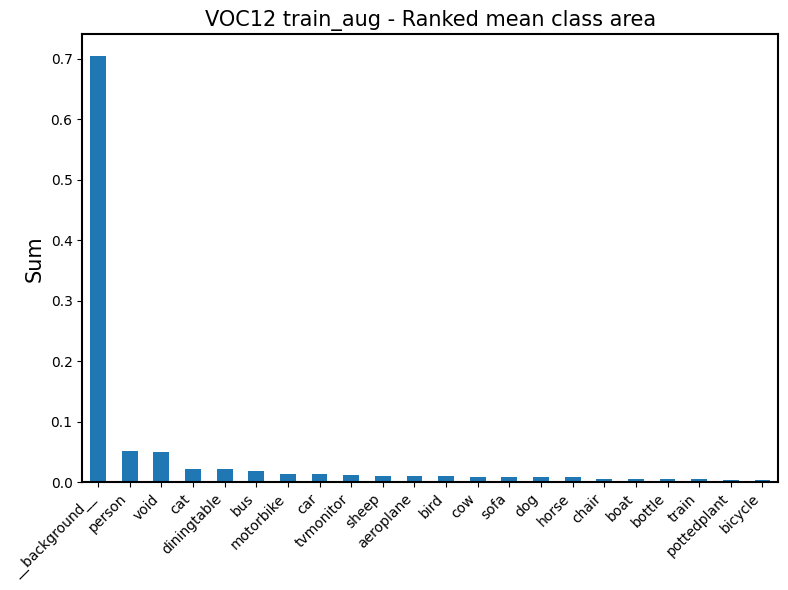

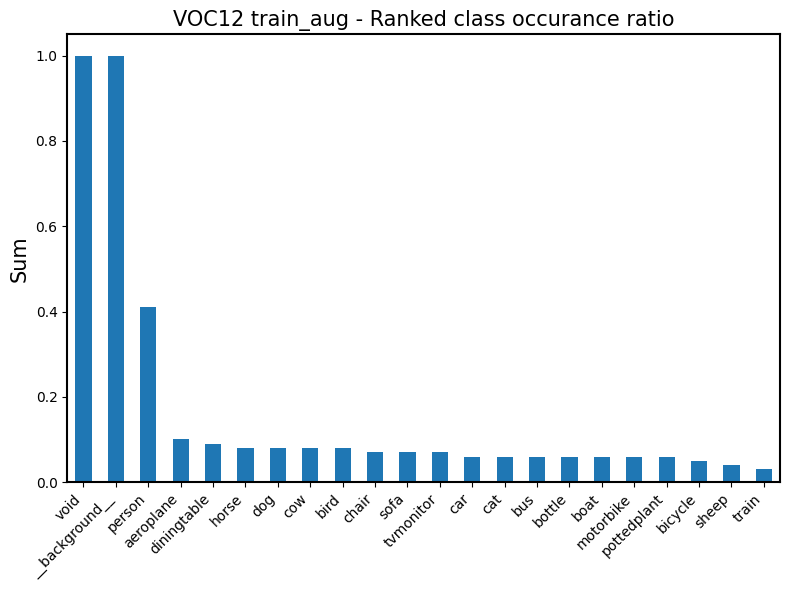

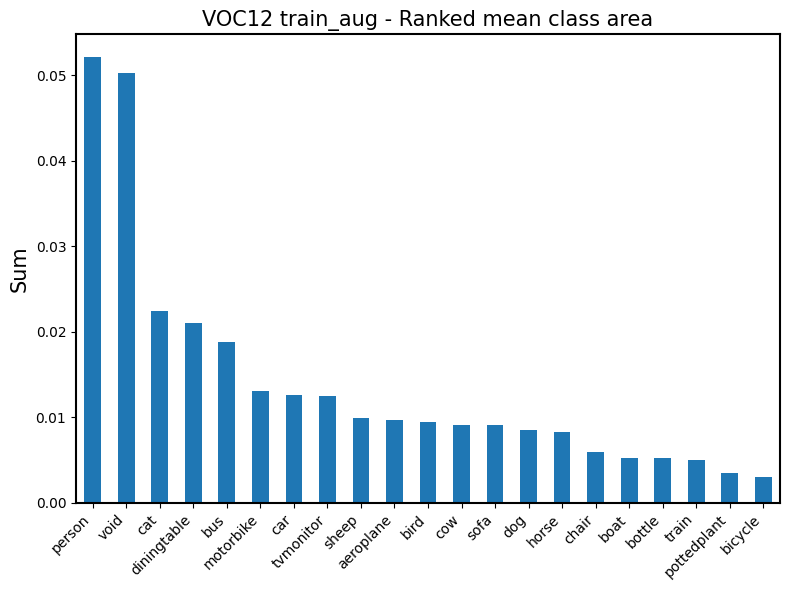

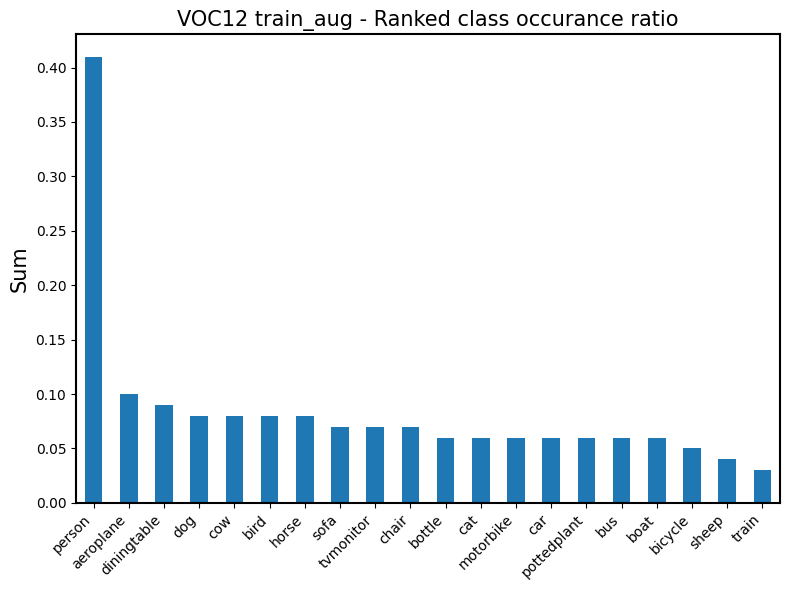

In [94]:
df_pascal_aug = df_pascal[df_pascal['split'] == 'train_aug'][PASCAL_CATEGORIES]
df = pd.DataFrame(df_pascal_aug)

ranked(df)

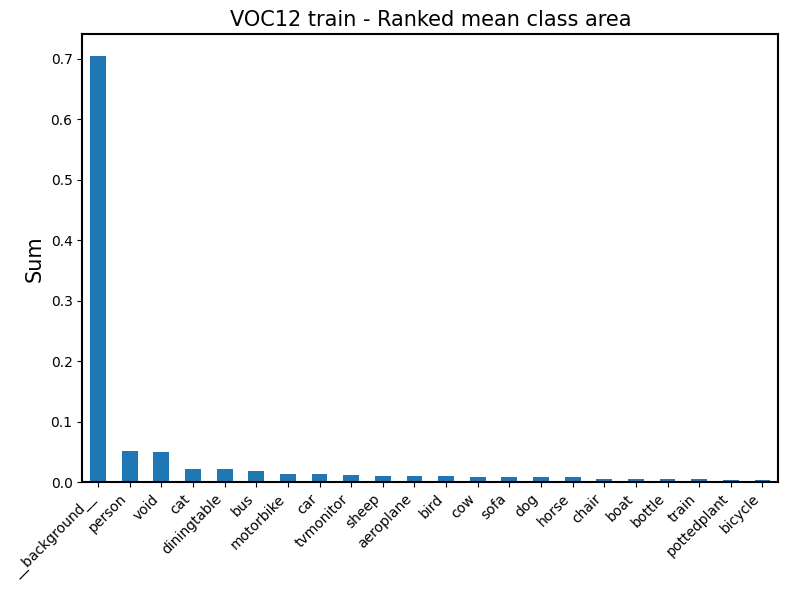

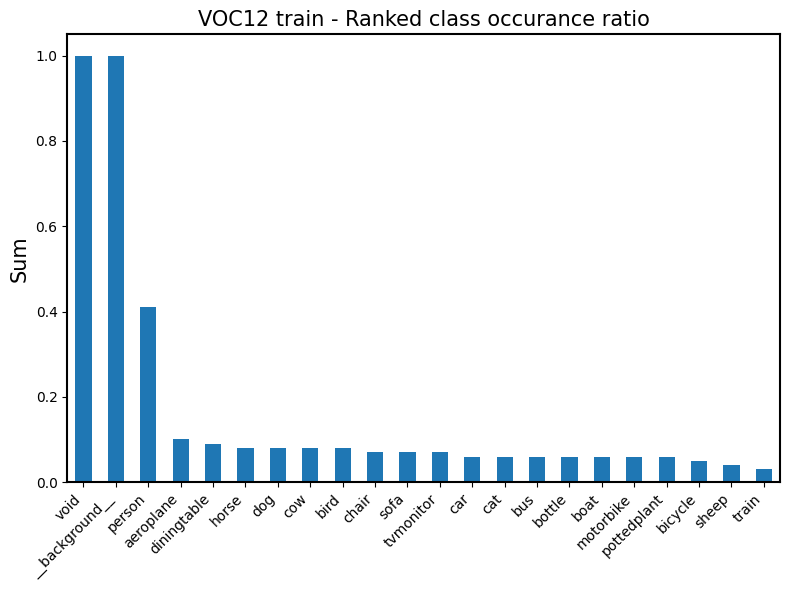

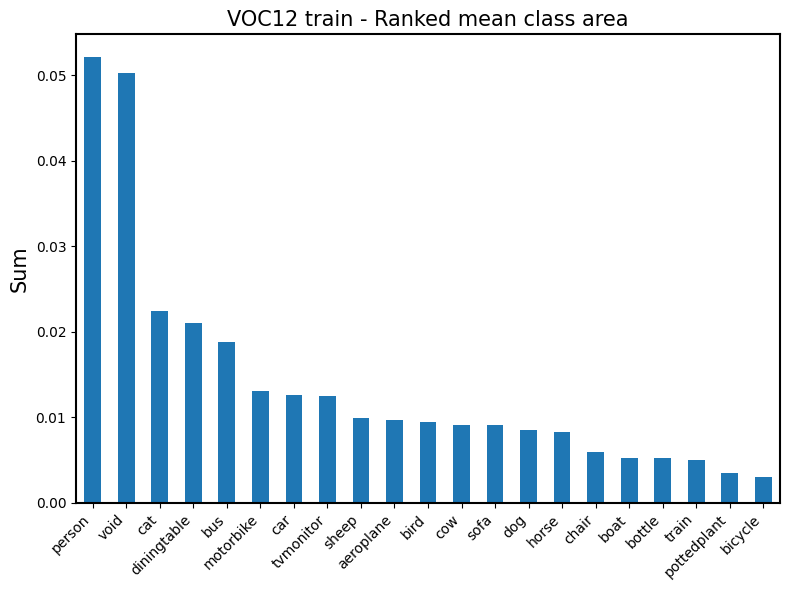

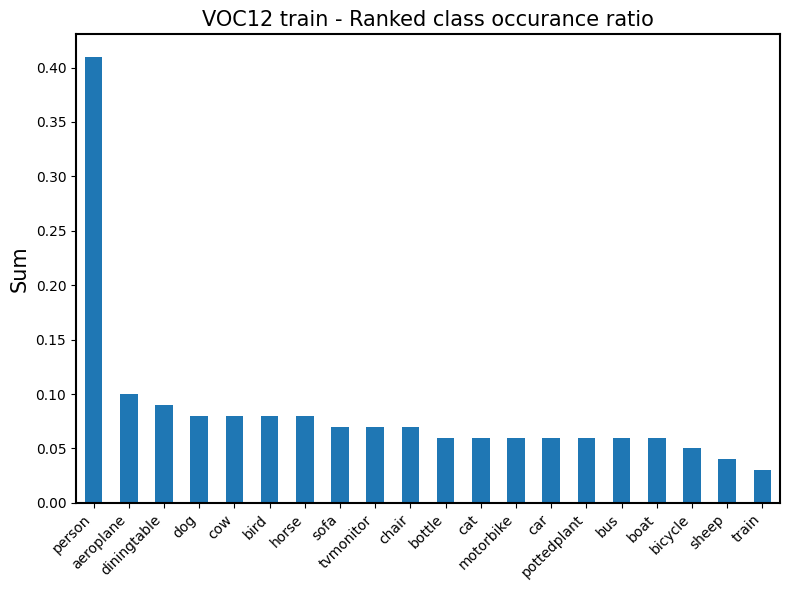

In [95]:
df_pascal_aug = df_pascal[df_pascal['split'] == 'train'][PASCAL_CATEGORIES]
df = pd.DataFrame(df_pascal_aug)

ranked(df, title_prep='VOC12 train - ')